In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

# LSTM Model applied on 2nd Dataset

In [3]:
data = pd.read_csv(r'C:\Users\hp\Downloads\APDS\Econometrics with R\RX_CACA5_Merged.csv')
data.head()

,time,voltage-I,voltage-II,voltage-III,current-I,current-II,current-III,wattage-I,wattage-II,wattage-III,...,drivingEndBearingTemp-II,nonDrivingEndBearingTemp-I,nonDrivingEndBearingTemp-II,deHorizontalVib,deVerticalVib,deAxialVib,nde_horizontalVib,nde_verticalVib,nde_axialVib,profile_id
0,10:47:56,11440,11470,11460,42.0,42.0,40,17000,4000,13000,...,36.2,35.7,34.1,1.3,1.0,0.7,1.0,1.0,1.1,5
1,10:48:57,10660,10700,10670,37.0,36.0,35,15000,3000,11000,...,36.9,36.2,34.6,1.3,1.0,0.8,1.0,1.0,1.1,5
2,10:49:58,10670,10710,10680,37.0,36.0,35,15000,3000,10000,...,37.5,36.6,35.0,1.3,1.1,0.9,1.1,1.2,1.1,5
3,10:50:58,10650,10700,10660,37.0,36.0,35,14000,3000,11000,...,38.2,37.0,35.4,1.3,1.0,0.9,1.1,1.1,1.0,5
4,10:51:58,10705,10755,10715,37.5,36.5,35,14500,3000,11000,...,38.8,37.3,35.7,1.3,1.1,1.0,1.2,1.2,1.2,5


In [4]:
lstm_data = data.copy()

In [5]:
#lstm_data
    
# Drop profile_id column
lstm_data = lstm_data.drop('profile_id', axis=1)

In [6]:
# Split df into X and y
data = lstm_data[['time', 'drivingEndBearingTemp-I', 'drivingEndBearingTemp-II']]
data

,time,drivingEndBearingTemp-I,drivingEndBearingTemp-II
0,10:47:56,35.9,36.2
1,10:48:57,36.5,36.9
2,10:49:58,37.2,37.5
3,10:50:58,37.8,38.2
4,10:51:58,38.5,38.8
...,...,...,...
176,13:46:07,59.6,60.0
177,13:47:08,59.6,60.0
178,13:48:09,59.6,59.9
179,13:49:09,59.5,59.9


In [7]:
#df['temp'] = data[['drivingEndBearingTemp-I', 'drivingEndBearingTemp-II','nonDrivingEndBearingTemp-I', 'nonDrivingEndBearingTemp-II'].mean(axis=1)

data['temp'] = data['drivingEndBearingTemp-I'] + data['drivingEndBearingTemp-II'] 
#data['temp'] = d['temp']/4
data['temp'] = data['temp'].div(2).round(2)

data = data.drop(['drivingEndBearingTemp-I', 'drivingEndBearingTemp-II'], axis=1)
#data = data.drop('time', axis=1)
data.head()

C:\Users\hp\AppData\Local\Temp\ipykernel_1604\3557252640.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['temp'] = data['drivingEndBearingTemp-I'] + data['drivingEndBearingTemp-II']
C:\Users\hp\AppData\Local\Temp\ipykernel_1604\3557252640.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['temp'] = data['temp'].div(2).round(2)


,time,temp
0,10:47:56,36.05
1,10:48:57,36.70
2,10:49:58,37.35
3,10:50:58,38.00
4,10:51:58,38.65


In [8]:
data.index = pd.to_datetime(data["time"], format='%H:%M:%S')
data = data.drop('time', axis=1)

In [9]:
data.shape

(181, 1)

In [10]:
data.head()

,temp
time,
1900-01-01 10:47:56,36.05
1900-01-01 10:48:57,36.70
1900-01-01 10:49:58,37.35
1900-01-01 10:50:58,38.00
1900-01-01 10:51:58,38.65


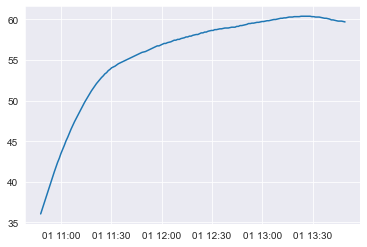

In [11]:
import matplotlib.pyplot as plt

plt.plot(data.index, data['temp'])

In [12]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [13]:
time_step = 5
a,b = df_to_X_y(data, time_step)
X2 = a.reshape(176,5,1)
y2 = b.reshape(176)
X2.shape, y2.shape

((176, 5, 1), (176,))

In [14]:
X2

array([[[36.05],
        [36.7 ],
        [37.35],
        [38.  ],
        [38.65]],

       [[36.7 ],
        [37.35],
        [38.  ],
        [38.65],
        [39.3 ]],

       [[37.35],
        [38.  ],
        [38.65],
        [39.3 ],
        [39.95]],

       [[38.  ],
        [38.65],
        [39.3 ],
        [39.95],
        [40.6 ]],

       [[38.65],
        [39.3 ],
        [39.95],
        [40.6 ],
        [41.2 ]],

       [[39.3 ],
        [39.95],
        [40.6 ],
        [41.2 ],
        [41.8 ]],

       [[39.95],
        [40.6 ],
        [41.2 ],
        [41.8 ],
        [42.4 ]],

       [[40.6 ],
        [41.2 ],
        [41.8 ],
        [42.4 ],
        [42.9 ]],

       [[41.2 ],
        [41.8 ],
        [42.4 ],
        [42.9 ],
        [43.5 ]],

       [[41.8 ],
        [42.4 ],
        [42.9 ],
        [43.5 ],
        [44.  ]],

       [[42.4 ],
        [42.9 ],
        [43.5 ],
        [44.  ],
        [44.5 ]],

       [[42.9 ],
        [43.5 ],
        [

In [15]:
y2

array([39.3 , 39.95, 40.6 , 41.2 , 41.8 , 42.4 , 42.9 , 43.5 , 44.  ,
       44.5 , 45.05, 45.5 , 46.  , 46.5 , 46.95, 47.4 , 47.8 , 48.2 ,
       48.6 , 49.  , 49.4 , 49.8 , 50.15, 50.5 , 50.85, 51.2 , 51.5 ,
       51.8 , 52.1 , 52.35, 52.6 , 52.85, 53.05, 53.3 , 53.45, 53.7 ,
       53.85, 54.05, 54.15, 54.25, 54.4 , 54.55, 54.65, 54.75, 54.85,
       54.95, 55.05, 55.15, 55.25, 55.35, 55.45, 55.55, 55.65, 55.75,
       55.85, 55.95, 56.  , 56.05, 56.15, 56.25, 56.35, 56.45, 56.55,
       56.65, 56.75, 56.75, 56.85, 56.95, 57.05, 57.05, 57.15, 57.2 ,
       57.25, 57.35, 57.45, 57.45, 57.55, 57.55, 57.65, 57.7 , 57.75,
       57.85, 57.85, 57.95, 57.95, 58.05, 58.1 , 58.15, 58.15, 58.25,
       58.35, 58.35, 58.45, 58.45, 58.55, 58.6 , 58.65, 58.65, 58.75,
       58.75, 58.8 , 58.85, 58.85, 58.9 , 58.95, 58.95, 58.95, 59.  ,
       59.05, 59.05, 59.05, 59.15, 59.15, 59.25, 59.25, 59.3 , 59.35,
       59.4 , 59.5 , 59.5 , 59.55, 59.55, 59.6 , 59.65, 59.65, 59.7 ,
       59.75, 59.75,

In [16]:
X_train2, y_train2 = X2[:100], y2[:100]
X_val2, y_val2 = X2[100:120], y2[100:120]
X_test2, y_test2 = X2[120:], y2[120:]
#X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [22]:
cp1 = ModelCheckpoint('model1', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.02), metrics=[RootMeanSquaredError()])

In [23]:
model1.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=35, callbacks=[cp1])

Epoch 1/35
1/4 [======>.......................] - ETA: 11s - loss: 0.0538 - root_mean_squared_error: 0.2320

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


4/4 [==============================] - 19s 5s/step - loss: 12.0408 - root_mean_squared_error: 3.4700 - val_loss: 3.5334 - val_root_mean_squared_error: 1.8797
Epoch 2/35
4/4 [==============================] - 0s 20ms/step - loss: 4.6242 - root_mean_squared_error: 2.1504 - val_loss: 4.7464 - val_root_mean_squared_error: 2.1786
Epoch 3/35
4/4 [==============================] - 0s 21ms/step - loss: 2.5703 - root_mean_squared_error: 1.6032 - val_loss: 5.3540 - val_root_mean_squared_error: 2.3139
Epoch 4/35
1/4 [======>.......................] - ETA: 0s - loss: 1.0510 - root_mean_squared_error: 1.0252

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


4/4 [==============================] - 14s 5s/step - loss: 1.7621 - root_mean_squared_error: 1.3274 - val_loss: 3.0629 - val_root_mean_squared_error: 1.7501
Epoch 5/35
4/4 [==============================] - 0s 18ms/step - loss: 1.7048 - root_mean_squared_error: 1.3057 - val_loss: 5.8173 - val_root_mean_squared_error: 2.4119
Epoch 6/35
1/4 [======>.......................] - ETA: 0s - loss: 1.0981 - root_mean_squared_error: 1.0479

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


4/4 [==============================] - 19s 6s/step - loss: 1.3871 - root_mean_squared_error: 1.1778 - val_loss: 2.5589 - val_root_mean_squared_error: 1.5997
Epoch 7/35
4/4 [==============================] - 0s 24ms/step - loss: 0.8017 - root_mean_squared_error: 0.8954 - val_loss: 3.6404 - val_root_mean_squared_error: 1.9080
Epoch 8/35
1/4 [======>.......................] - ETA: 0s - loss: 0.8890 - root_mean_squared_error: 0.9429

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


4/4 [==============================] - 18s 6s/step - loss: 0.7077 - root_mean_squared_error: 0.8412 - val_loss: 1.6226 - val_root_mean_squared_error: 1.2738
Epoch 9/35
4/4 [==============================] - 0s 16ms/step - loss: 0.5094 - root_mean_squared_error: 0.7137 - val_loss: 2.5285 - val_root_mean_squared_error: 1.5901
Epoch 10/35
1/4 [======>.......................] - ETA: 0s - loss: 0.5535 - root_mean_squared_error: 0.7440

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


4/4 [==============================] - 15s 5s/step - loss: 0.3895 - root_mean_squared_error: 0.6241 - val_loss: 0.8270 - val_root_mean_squared_error: 0.9094
Epoch 11/35
4/4 [==============================] - 0s 15ms/step - loss: 0.2466 - root_mean_squared_error: 0.4965 - val_loss: 1.2665 - val_root_mean_squared_error: 1.1254
Epoch 12/35
4/4 [==============================] - 0s 15ms/step - loss: 0.2158 - root_mean_squared_error: 0.4645 - val_loss: 0.8382 - val_root_mean_squared_error: 0.9155
Epoch 13/35
1/4 [======>.......................] - ETA: 0s - loss: 0.1546 - root_mean_squared_error: 0.3932

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


4/4 [==============================] - 16s 5s/step - loss: 0.1407 - root_mean_squared_error: 0.3751 - val_loss: 0.4356 - val_root_mean_squared_error: 0.6600
Epoch 14/35
1/4 [======>.......................] - ETA: 0s - loss: 0.0613 - root_mean_squared_error: 0.2475

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


4/4 [==============================] - 16s 5s/step - loss: 0.1207 - root_mean_squared_error: 0.3474 - val_loss: 0.2819 - val_root_mean_squared_error: 0.5309
Epoch 15/35
4/4 [==============================] - 0s 21ms/step - loss: 0.1510 - root_mean_squared_error: 0.3886 - val_loss: 0.4773 - val_root_mean_squared_error: 0.6908
Epoch 16/35
4/4 [==============================] - 0s 21ms/step - loss: 0.0789 - root_mean_squared_error: 0.2810 - val_loss: 0.3091 - val_root_mean_squared_error: 0.5559
Epoch 17/35
1/4 [======>.......................] - ETA: 0s - loss: 0.0436 - root_mean_squared_error: 0.2089

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


4/4 [==============================] - 15s 5s/step - loss: 0.1017 - root_mean_squared_error: 0.3188 - val_loss: 0.1564 - val_root_mean_squared_error: 0.3954
Epoch 18/35
4/4 [==============================] - 0s 24ms/step - loss: 0.1511 - root_mean_squared_error: 0.3887 - val_loss: 0.6000 - val_root_mean_squared_error: 0.7746
Epoch 19/35
4/4 [==============================] - 0s 22ms/step - loss: 0.1616 - root_mean_squared_error: 0.4020 - val_loss: 0.1914 - val_root_mean_squared_error: 0.4375
Epoch 20/35
4/4 [==============================] - 0s 22ms/step - loss: 0.1158 - root_mean_squared_error: 0.3403 - val_loss: 0.2697 - val_root_mean_squared_error: 0.5193
Epoch 21/35
4/4 [==============================] - 0s 22ms/step - loss: 0.0872 - root_mean_squared_error: 0.2953 - val_loss: 0.1615 - val_root_mean_squared_error: 0.4019
Epoch 22/35
4/4 [==============================] - 0s 22ms/step - loss: 0.0709 - root_mean_squared_error: 0.2662 - val_loss: 0.2505 - val_root_mean_squared_error: 

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


4/4 [==============================] - 16s 5s/step - loss: 0.0427 - root_mean_squared_error: 0.2067 - val_loss: 0.0764 - val_root_mean_squared_error: 0.2764
Epoch 24/35
4/4 [==============================] - 0s 18ms/step - loss: 0.0761 - root_mean_squared_error: 0.2758 - val_loss: 0.1508 - val_root_mean_squared_error: 0.3883
Epoch 25/35
1/4 [======>.......................] - ETA: 0s - loss: 0.0438 - root_mean_squared_error: 0.2092

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


4/4 [==============================] - 16s 5s/step - loss: 0.0838 - root_mean_squared_error: 0.2895 - val_loss: 0.0740 - val_root_mean_squared_error: 0.2721
Epoch 26/35
4/4 [==============================] - 0s 19ms/step - loss: 0.0909 - root_mean_squared_error: 0.3014 - val_loss: 0.2141 - val_root_mean_squared_error: 0.4627
Epoch 27/35
4/4 [==============================] - 0s 19ms/step - loss: 0.0679 - root_mean_squared_error: 0.2605 - val_loss: 0.2430 - val_root_mean_squared_error: 0.4930
Epoch 28/35
4/4 [==============================] - 0s 19ms/step - loss: 0.1375 - root_mean_squared_error: 0.3708 - val_loss: 0.6976 - val_root_mean_squared_error: 0.8352
Epoch 29/35
4/4 [==============================] - 0s 18ms/step - loss: 0.1645 - root_mean_squared_error: 0.4056 - val_loss: 0.2551 - val_root_mean_squared_error: 0.5051
Epoch 30/35
4/4 [==============================] - 0s 19ms/step - loss: 0.0541 - root_mean_squared_error: 0.2327 - val_loss: 0.3911 - val_root_mean_squared_error: 

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


4/4 [==============================] - 17s 6s/step - loss: 0.0352 - root_mean_squared_error: 0.1875 - val_loss: 0.0616 - val_root_mean_squared_error: 0.2483
Epoch 35/35
4/4 [==============================] - 0s 21ms/step - loss: 0.0519 - root_mean_squared_error: 0.2278 - val_loss: 0.0995 - val_root_mean_squared_error: 0.3154


In [24]:
from tensorflow.keras.models import load_model
model1 = load_model('model1')

In [25]:
train_predictions2 = model1.predict(X_train2).flatten()
train_results2 = pd.DataFrame(data={'Train Predictions2':train_predictions2, 'Train Actuals2':y_train2})
train_results2

4/4 [==============================] - 1s 4ms/step


,Train Predictions2,Train Actuals2
0,39.861549,39.30
1,40.262363,39.95
2,40.691784,40.60
3,41.163555,41.20
4,41.669991,41.80
...,...,...
95,58.584114,58.60
96,58.617783,58.65
97,58.652824,58.65
98,58.670685,58.75


In [27]:
val_predictions2 = model1.predict(X_val2).flatten()
val_results2 = pd.DataFrame(data={'Val Predictions2':val_predictions2, 'Val Actuals2':y_val2})
val_results2

1/1 [==============================] - 0s 36ms/step


,Val Predictions2,Val Actuals2
0,58.721287,58.80
1,58.745995,58.85
2,58.768661,58.85
3,58.783188,58.90
4,58.802101,58.95
5,58.823090,58.95
6,58.837288,58.95
7,58.844147,59.00
8,58.856499,59.05
9,58.876019,59.05


In [28]:
test_predictions2 = model1.predict(X_test2).flatten()
test_results2 = pd.DataFrame(data={'Test Predictions2':test_predictions2, 'Actuals2':y_test2})
test_results2

2/2 [==============================] - 0s 4ms/step


,Test Predictions2,Actuals2
0,59.103584,59.55
1,59.124275,59.55
2,59.132591,59.60
3,59.147213,59.65
4,59.164722,59.65
5,59.176037,59.70
6,59.191216,59.75
7,59.208130,59.75
8,59.219070,59.80
9,59.233829,59.85


In [29]:
from sklearn.metrics import mean_squared_error
import math
math.sqrt(mean_squared_error(test_predictions2, y_test2))

0.7321711100706072

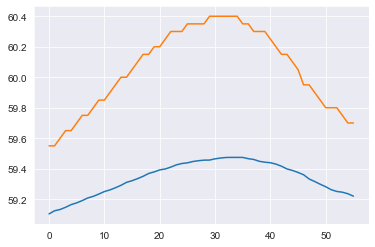

In [30]:
plt.plot(test_results2['Test Predictions2'][:])
plt.plot(test_results2['Actuals2'][:])

In [31]:
from sklearn.metrics import mean_squared_error as mse
def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)

2/2 [==============================] - 0s 7ms/step


(    Predictions  Actuals
 0     59.103584    59.55
 1     59.124275    59.55
 2     59.132591    59.60
 3     59.147213    59.65
 4     59.164722    59.65
 5     59.176037    59.70
 6     59.191216    59.75
 7     59.208130    59.75
 8     59.219070    59.80
 9     59.233829    59.85
 10    59.250275    59.85
 11    59.260857    59.90
 12    59.275208    59.95
 13    59.291195    60.00
 14    59.310566    60.00
 15    59.321381    60.05
 16    59.335014    60.10
 17    59.350338    60.15
 18    59.368862    60.15
 19    59.379158    60.20
 20    59.392212    60.20
 21    59.398308    60.25
 22    59.410591    60.30
 23    59.425190    60.30
 24    59.434273    60.30
 25    59.438522    60.35
 26    59.447327    60.35
 27    59.452568    60.35
 28    59.456192    60.35
 29    59.456741    60.40
 30    59.464890    60.40
 31    59.470161    60.40
 32    59.473717    60.40
 33    59.474266    60.40
 34    59.474140    60.40
 35    59.474140    60.35
 36    59.465897    60.35
 37    59.46

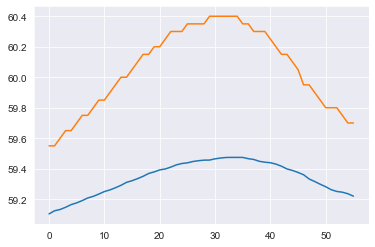

In [32]:
plot_predictions1(model1, X_test2, y_test2)

In [33]:
#If predicted value is greater than 65 then motor is rejected

print("******************************************************")
if ((test_results2["Test Predictions2"]>65).any()):
    print("Keep Motor running, predicted value is greater than 65 degrees!!!")
else:
    print("Motor Validation Passed!!!")
print("******************************************************")

******************************************************
Motor Validation Passed!!!
******************************************************
